In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

### System timeline
 - initial raise
 - hatch sale
 - reference implementation launch

# Augumented bonding curve Mathematics

### Hatch Sale Equations

- Initial Raise $d_0$ Dai
- Initial Reserve is $R_0 = (1-\theta) d_0$
- Hatch sale Price $p_0$ (dai per token) determines the initial supply: $S_0 = d_0/p_0$
- Power Function Invariant shape: $V(R, S) = \frac{S^\kappa}{R}$
- Price function (DAI per Token): $P(R) = \frac{\kappa R^{(\kappa-1)/ \kappa}}{V_0^{1 / \kappa}}$
- Supply function (tokens): $S(R) = \sqrt[\kappa]{V_0 R}$
- Reserve function (xDAI): $R(S) = \frac{S^{\kappa}}{V_0} $
- The invariant coef: $V_0 = V(R_0, S_0) = \frac{S_0^\kappa}{R_0} = \left(\frac{1}{p_0(1-\theta)}\right)^\kappa R_0^{\kappa-1}$
- The post hatch price: $p_1=P(R_0) = \frac{\kappa R_0^{(\kappa-1)/ \kappa}}{V_0^{1 / \kappa}} = \kappa R_0^{(\kappa-1)/ \kappa} \cdot(1-\theta)p_0\cdot R_0^{-(\kappa-1)/\kappa} = \kappa(1-\theta) p_0$
- The Return factor: $\frac{p_1}{p_0} = {\kappa}(1-\theta)$

### Invariant Preserving Deposit-to-Mint
 - Deposit $\Delta R$ xdai 
 - Conservation equation: $V(R+ \Delta R, S+\Delta S) = \frac{(S+\Delta S)^\kappa}{R+\Delta R} =V_0$
 - Derived Mint equation: $\Delta S = mint\big(\Delta R ; (R,S)\big)= \sqrt[\kappa]{V_0(R+\Delta R)}-S$
 - Realized Price is: $\bar{P}(\Delta R) =\frac{\Delta R}{\Delta S} = \frac{\Delta R}{\sqrt[\kappa]{V_0(R+\Delta R)}-\sqrt[\kappa]{V_0(R)}} \rightarrow \big(\frac{\partial S(R)}{\partial R} \big)^{-1}$ as $\Delta R \rightarrow 0$
 - The limiting price is the spot price: $\lim_{\Delta R \rightarrow 0} \bar{P}(\Delta R)=\big(\frac{\partial S(R)}{\partial R}\big)^{-1}= \big(\frac{V_0^{1/\kappa} \cdot  R^{1/\kappa-1}}{\kappa}\big)^{-1}= \frac{\kappa R^{1-1/\kappa}}{V_0^{1/\kappa}} = \frac{\kappa R^{(\kappa-1)/\kappa}}{V_0^{1/\kappa}} =P(R)$
 
### Invariant Preserving Burn-to-Withdraw
 - Burn $\Delta S$ tokens
 - Conservation equation: $V(R- \Delta R, S-\Delta S) = \frac{(S-\Delta S)^\kappa}{R-\Delta R} =V_0$
 - Derived Withdraw equation: $\Delta R = withdraw\big(\Delta S ; (R,S)\big)= R-\frac{(S-\Delta S)^\kappa}{V_0}$
 - Realized Price is: $\bar{P}(\Delta S) =\frac{\Delta R}{\Delta S} = \frac{\frac{S^{\kappa}}{V_0}-\frac{(S-\Delta S)^\kappa}{V_0}}{\Delta S} \rightarrow \frac{\partial R(S)}{\partial S} $ as $\Delta S \rightarrow 0$
 - The limiting price is the spot price: $\lim_{\Delta S \rightarrow 0} \bar{P}(\Delta S)=\frac{\partial R(S)}{\partial S}=\frac{\kappa S^{\kappa-1}}{V_0} = \frac{\kappa \cdot (\sqrt[\kappa]{V_0 R})^{\kappa-1}}{V_0}= \frac{\kappa R^{(\kappa-1)/\kappa}}{V_0^{1/\kappa}}=P(R)$
 - Given friction coef $\phi$ 
     - sent to burning agent address: $\Delta R_{agent} = (1-\phi) \Delta R$
     - sent to the funding pool address: $\Delta R_{pool} = \phi \Delta R$
     - due to the friction the true realized price for the agent is $(1-\phi)\cdot \bar{P}(\Delta S)$
     - due to the friction the true return factor post withdraw is: ${\kappa}(1-\theta)(1-\phi)$

In [2]:
#integer_units = 10**12 #account for decimal places to a token
#scale_units = 10**6 #millions of tokens, million of DAI
#mu = integer_units*scale_units

#value function for a given state (R,S)
def invariant(R,S,kappa):
    return (S**kappa)/R

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return Supply S as a function of reserve R
def supply(R, kappa, V0):
    return (V0*R)**(1/kappa)

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return a spot price P as a function of reserve R
def spot_price(R, kappa, V0):
    return kappa*R**((kappa-1)/kappa)/V0**(1/kappa)

#for a given state (R,S)
#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#deposit deltaR to Mint deltaS
#with realized price deltaR/deltaS
def mint(deltaR, R,S, kappa, V0):
    deltaS = (V0*(R+deltaR))**(1/kappa)-S
    realized_price = deltaR/deltaS
    return deltaS, realized_price

#for a given state (R,S)
#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#burn deltaS to Withdraw deltaR
#with realized price deltaR/deltaS
def withdraw(deltaS, R,S, kappa, V0):
    deltaR = R-((S-deltaS)**kappa)/V0
    realized_price = deltaR/deltaS
    return deltaR, realized_price

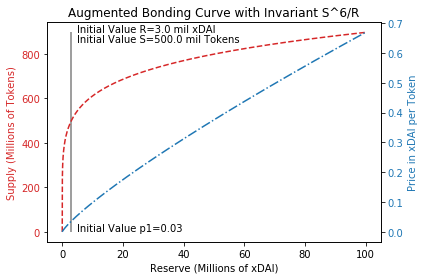

In [3]:
d0 = 5 #million DAI
p0 = .01 #DAI per tokens
theta = .4

R0 =  d0*(1-theta) #million DAI
S0 = d0/p0

kappa = 6
V0 = invariant(R0,S0,kappa)

reserve = np.arange(0,100,.01)
supp = np.array([supply(r,kappa, V0) for r in reserve])
price = np.array([spot_price(r,kappa, V0) for r in reserve])

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Reserve (Millions of xDAI)')
ax1.set_ylabel('Supply (Millions of Tokens)', color=color)
ax1.plot(reserve, supp,'--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Price in xDAI per Token', color=color)  # we already handled the x-label with ax1
ax2.plot(reserve, price,'-.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.vlines(R0,0,supp[-1], alpha=.5)
ax1.text(R0+.02*reserve[-1], supp[-1], "Initial Value R="+str(int(100*R0)/100)+" mil xDAI")
ax1.text(R0+.02*reserve[-1], .95*supp[-1], "Initial Value S="+str(S0)+" mil Tokens")
#ax1.hlines(S0,0,R0)

ax2.text(R0+.02*reserve[-1], price[3], "Initial Value p1="+str(int(100*spot_price(R0,kappa,V0))/100))


plt.title('Augmented Bonding Curve with Invariant S^'+str(kappa)+'/R')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

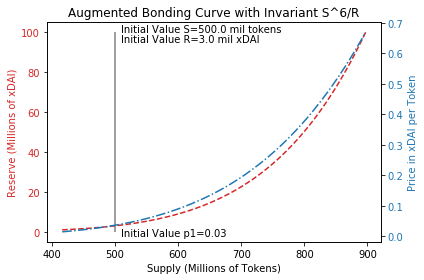

In [4]:
fig, ax1 = plt.subplots()

cp = 100
color = 'tab:red'
ax1.set_xlabel('Supply (Millions of Tokens)')
ax1.set_ylabel('Reserve (Millions of xDAI)', color=color)
ax1.plot(supp[cp:], reserve[cp:],'--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Price in xDAI per Token', color=color)  # we already handled the x-label with ax1
ax2.plot(supp[cp:], price[cp:],'-.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.vlines(S0,0,reserve[-1], alpha=.5)
ax1.text(S0*1.02, reserve[-1], "Initial Value S="+str(int(100*S0)/100)+" mil tokens")
ax1.text(S0*1.02, .95*reserve[-1], "Initial Value R="+str(R0)+" mil xDAI")
#ax1.hlines(S0,0,R0)

ax2.text(S0*1.02, price[3], "Initial Value p1="+str(int(100*spot_price(R0,kappa,V0))/100))


plt.title('Augmented Bonding Curve with Invariant S^'+str(kappa)+'/R')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [5]:
#given V0 and kappa
#sweep the reserve
reserve = None
reserve = np.arange(.01,100,.01)
price = np.array([spot_price(r,kappa, V0) for r in reserve])

#realized price for withdrawing burning .1% of tokens
withdraw_price=[withdraw(supply(r,kappa,V0)/1000, r,supply(r,kappa,V0), kappa, V0)[1] for r in reserve]

#realized price for depositing .1% more Xdai into the reserve
mint_price=[mint(r/1000, r, supply(r,kappa,V0), kappa, V0)[1] for r in reserve]

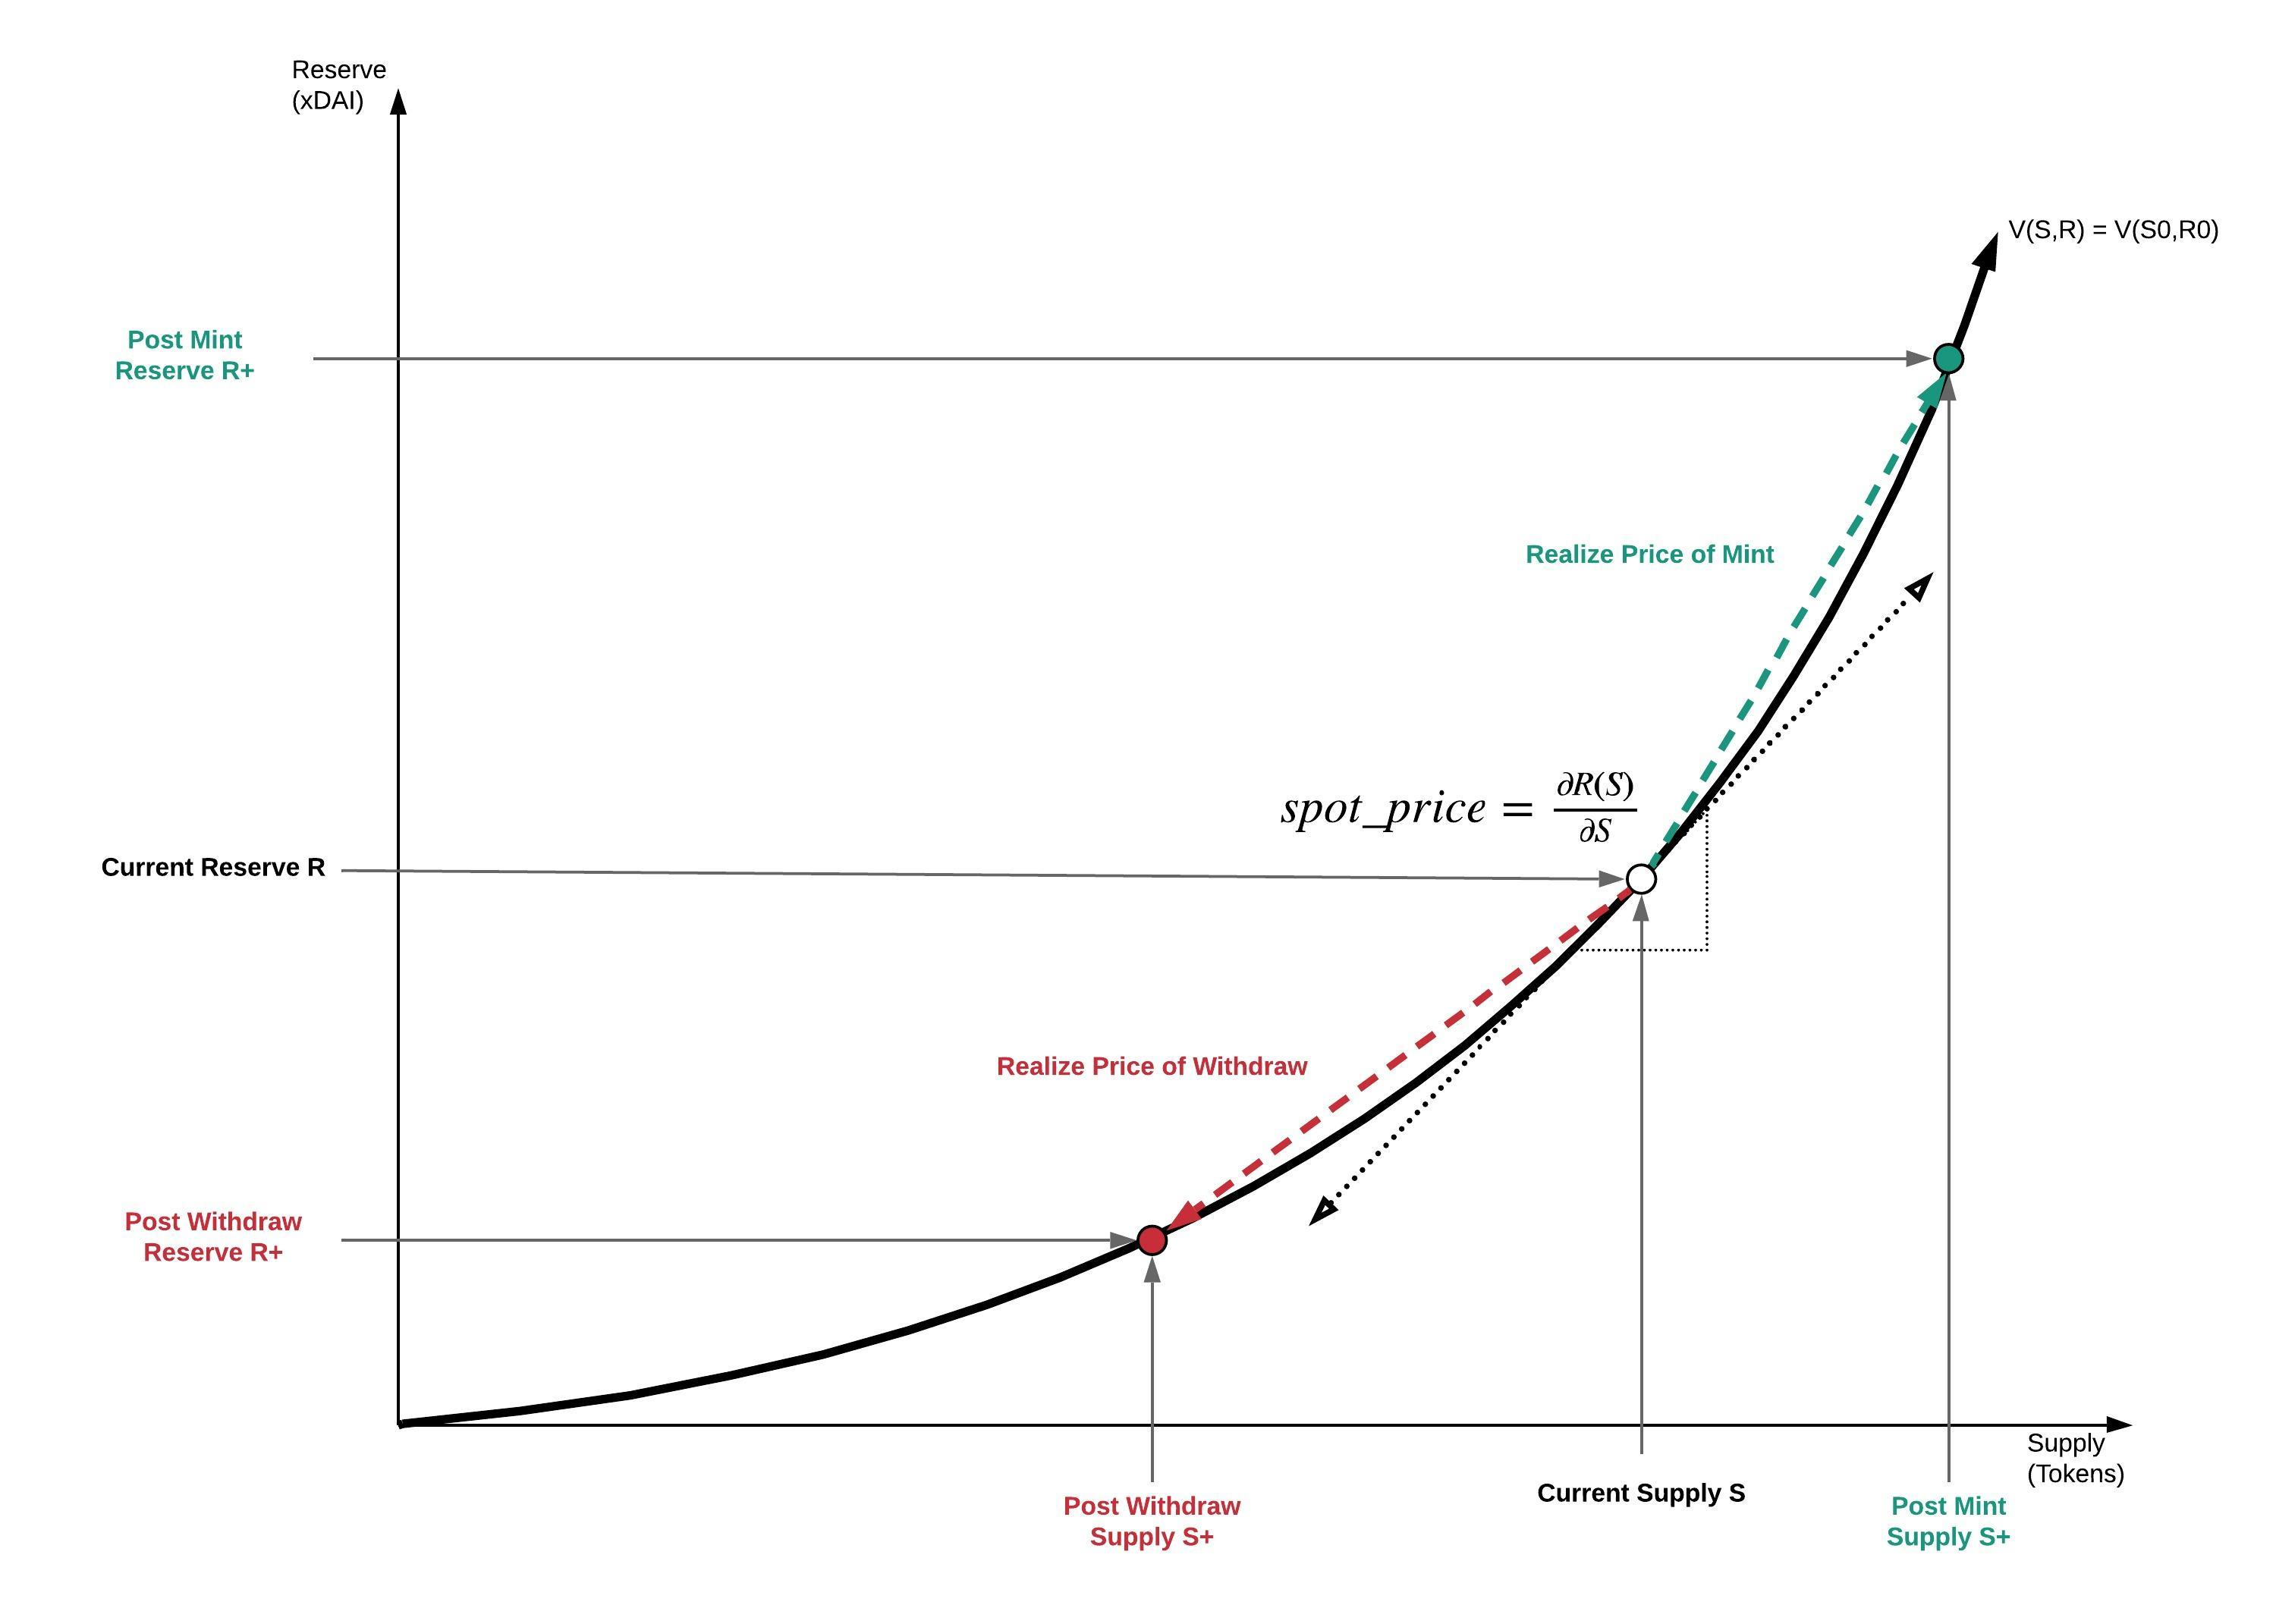

In [6]:
from IPython.display import Image
Image(filename='slippage.jpeg')

In [7]:
pdf = pd.DataFrame({'reserve':reserve, 'spot_price':price, '.1% mint_price':mint_price,'.1% withdraw_price':withdraw_price })

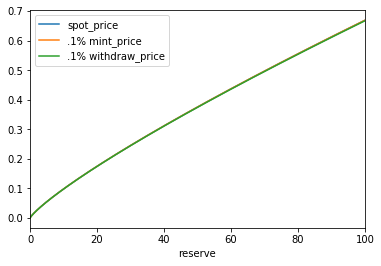

In [8]:
pdf.plot(x='reserve')

In [9]:
pdf['mint_slippage'] = (pdf['.1% mint_price']-pdf['spot_price'])/pdf['spot_price']
pdf['withdraw_slippage'] = (pdf['spot_price']-pdf['.1% withdraw_price'])/pdf['spot_price']

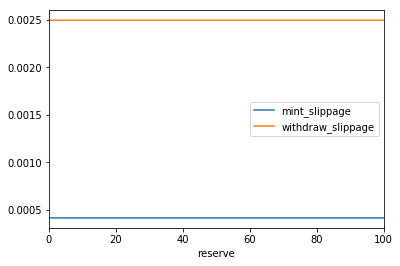

In [10]:
pdf.plot(x='reserve', y = ['mint_slippage', 'withdraw_slippage'])#, logy=True)

In [11]:
#given V0 and kappa
R = 20
S = supply(R,kappa,V0)
p = spot_price(R,kappa,V0)
#sweep the transaction fraction
TXF = np.logspace(-6, 0, num=1000)

#realized price for withdrawing burning .1% of tokens
withdraw_price2=[withdraw(S*txf, R,S, kappa, V0)[1] for txf in TXF]

#realized price for depositing .1% more Xdai into the reserve
mint_price2=[mint(R*txf, R,S, kappa, V0)[1] for txf in TXF]

In [12]:
print(S)

685.9431568581422


In [13]:
pdf2 = pd.DataFrame({'tx_fraction':TXF, 'spot_price':p*np.ones(len(TXF)), 'mint_price':mint_price2,'withdraw_price':withdraw_price2 })

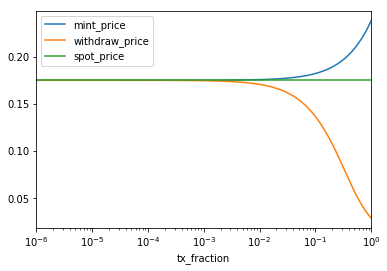

In [14]:
pdf2.plot(x='tx_fraction',y=['mint_price','withdraw_price','spot_price'], logx=True)

In [15]:
pdf2['mint_slippage'] = (pdf2['mint_price']-pdf2['spot_price'])/pdf2['spot_price']
pdf2['withdraw_slippage'] = (pdf2['spot_price']-pdf2['withdraw_price'])/pdf2['spot_price']

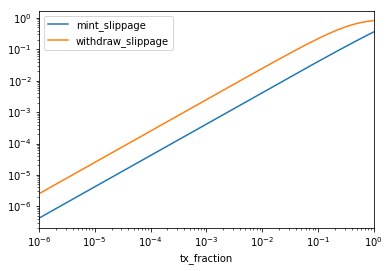

In [16]:
pdf2.plot(x='tx_fraction', y = ['mint_slippage', 'withdraw_slippage'], logx=True, logy=True)

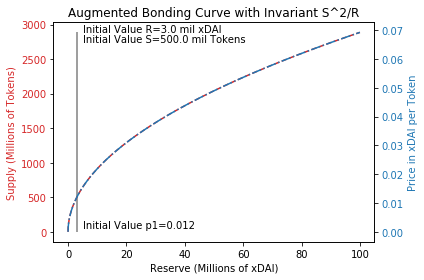

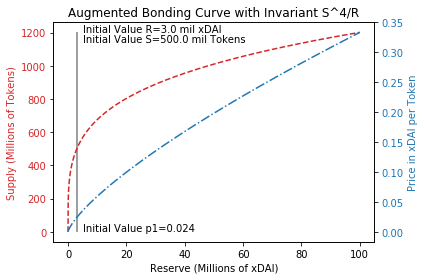

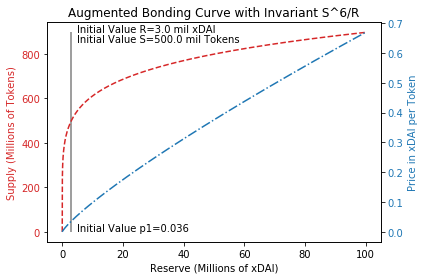

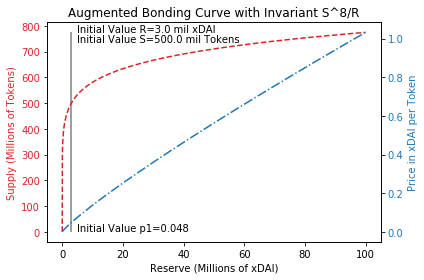

In [24]:
Kappa_List = [2,4,6,8]
for kappa in Kappa_List:
    
    V0 = invariant(R0,S0,kappa)
    
    reserve = np.arange(0,100,.01)
    supp = np.array([supply(r,kappa, V0) for r in reserve])
    price = np.array([spot_price(r,kappa, V0) for r in reserve])

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Reserve (Millions of xDAI)')
    ax1.set_ylabel('Supply (Millions of Tokens)', color=color)
    ax1.plot(reserve, supp,'--', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Price in xDAI per Token', color=color)  # we already handled the x-label with ax1
    ax2.plot(reserve, price,'-.', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.vlines(R0,0,supp[-1], alpha=.5)
    ax1.text(R0+.02*reserve[-1], supp[-1], "Initial Value R="+str(int(100*R0)/100)+" mil xDAI")
    ax1.text(R0+.02*reserve[-1], .95*supp[-1], "Initial Value S="+str(int(100*S0)/100)+" mil Tokens")
    #ax1.hlines(S0,0,R0)

    ax2.text(R0+.02*reserve[-1], price[3], "Initial Value p1="+str(int(1000*spot_price(R0,kappa,V0))/1000))


    plt.title('Augmented Bonding Curve with Invariant S^'+str(kappa)+'/R')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [18]:
#Power function independent variables for analysis
vec_d0 = np.arange(2.5,5.1,.1) #millon dai
vec_theta = np.arange(.1,.55,.05) #unitless
mat_R0 = np.outer(vec_d0.T, (1-vec_theta)) #million dai
vec_p0 = np.arange(.01,.11,.01) #dai per token
mat_S0 = np.outer(vec_d0.T, vec_p0) #milion tokens
vec_kappa = np.arange(2,9,1) #integer

mat_return_ratio = np.outer(vec_kappa.T, (1-vec_theta))

Text(0.5, 1.0, 'Hatch Return Rate p1/p0')

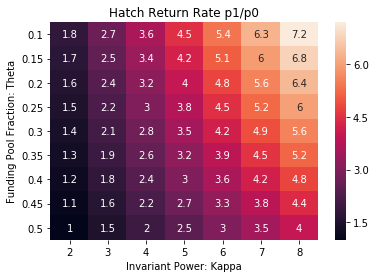

In [19]:
p0_lab = [str(int(100*p)/100) for p in vec_p0] 
th_lab = [str(int(100*th)/100) for th in vec_theta]
k_lab = [str(k) for k in vec_kappa] 
sns.heatmap(mat_return_ratio.T,yticklabels=th_lab, xticklabels=k_lab, annot=True)
plt.yticks(rotation=0)
plt.xlabel('Invariant Power: Kappa')
plt.ylabel('Funding Pool Fraction: Theta')
plt.title('Hatch Return Rate p1/p0')

Text(0.5, 1.0, 'Funding Pool Funds at Launch (Millions of xDAI)')

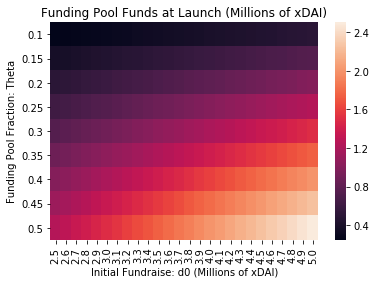

In [20]:
d_lab = [str(int(100*d)/100) for d in vec_d0] 
sns.heatmap(vec_d0-mat_R0.T,yticklabels=th_lab, xticklabels=d_lab)#, annot=True)
plt.yticks(rotation=0)

plt.xlabel('Initial Fundraise: d0 (Millions of xDAI)')
plt.ylabel('Funding Pool Fraction: Theta')
plt.title('Funding Pool Funds at Launch (Millions of xDAI)')

Text(0.5, 15.0, 'Intial Raise d0 (Millions of xDAI)')

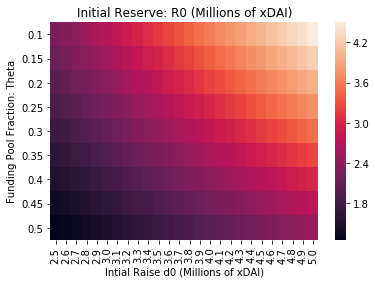

In [21]:
d_lab = [str(int(100*d)/100) for d in vec_d0] 
sns.heatmap(mat_R0.T,yticklabels=th_lab, xticklabels=d_lab)#, annot=True)
plt.yticks(rotation=0)

plt.title('Initial Reserve: R0 (Millions of xDAI)')
plt.ylabel('Funding Pool Fraction: Theta')
plt.xlabel('Intial Raise d0 (Millions of xDAI)')

Text(0.5, 15.0, 'Intial Raise d0 (Millions of xDAI)')

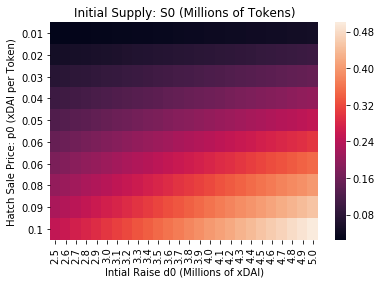

In [22]:
sns.heatmap(mat_S0.T,yticklabels=p0_lab, xticklabels=d_lab)#, annot=True)
plt.yticks(rotation=0)

plt.title('Initial Supply: S0 (Millions of Tokens)')
plt.ylabel('Hatch Sale Price: p0 (xDAI per Token)')
plt.xlabel('Intial Raise d0 (Millions of xDAI)')